# A-scan from a metal cylinder (2D)

This example is the GPR modelling equivalent of 'Hello World'! It demonstrates how to simulate a single trace (A-scan) from a metal cylinder buried in a dielectric half-space. The input needed to create the model is:

### my_cylinder_Ascan_2D.in

In [4]:
%%writefile ../../user_models/cylinder_Ascan_2D.in
#title: A-scan from a metal cylinder buried in a dielectric half-space
#domain: 0.240 0.210 0.002
#dx_dy_dz: 0.002 0.002 0.002
#time_window: 3e-9

#material: 6 0 1 0 half_space

#waveform: ricker 1 1.5e9 my_ricker
#hertzian_dipole: z 0.100 0.170 0 my_ricker
#rx: 0.140 0.170 0

#box: 0 0 0 0.240 0.170 0.002 half_space
#cylinder: 0.120 0.080 0 0.120 0.080 0.002 0.010 pec

#geometry_view: 0 0 0 0.240 0.210 0.002 0.002 0.002 0.002 cylinder_half_space n

Overwriting ../../user_models/cylinder_Ascan_2D.in


### Geometry of a metal cylinder buried in a dielectric half-space
<img style="float: left" src="cylinder_half_space_geo.png" width="50%" height="50%" />

The geometry of the scenario is straightforward - the transparent area around the boundary of the domain represents the PML region. The red cell is the source and the blue cell is the receiver.

For this initial example a detailed description of what each command in the input file does and why each command was used is given. The following steps explain the process of building the input file:

### 1. Determine the constitutive parameters for the materials

There will be three different materials in the model representing air, the dielectric half-space, and the metal cylinder. Air (free space) already exists as a built-in material in gprMax which can be accessed using the ``free_space`` identifier. The metal cylinder will be modelled as a Perfect Electric Conductor, which again exists as a built-in material in gprMax and can be accessed using the ``pec`` identifier. So the only material which has to be defined is for the dielectric half-space. It is a non-magnetic material, i.e. $\mu_r=1$ and $\sigma_*=0$ and with a relative permittivity of six, $\epsilon_r=6$, and zero conductivity, $\sigma=0$. The identifier ``half_space`` will be used.

    #material: 6 0 1 0 half_space

### 2. Determine the source type and excitation frequency

These should generally be known, often based on the GPR system or scenario being modelled. Low frequencies are used where significant penetration depth is important, whereas high frequencies are used where less penetration and better resolution are required. In this case a theoretical Hertzian dipole source fed with a Ricker waveform with a centre frequency of $f_c=1.5~\textrm{GHz}$ will be used to simulate the GPR antenna (see the bowtie antenna example model for how to include a model of the actual GPR antenna in the simulation).

    #waveform: ricker 1 1.5e9 my_ricker
    #hertzian_dipole: z 0.100 0.170 0 my_ricker

The Ricker waveform is created with the ``#waveform`` command, specifying an amplitude of one, centre frequency of 1.5 GHz and picking an arbitrary identifier of ``my_ricker``. The Hertzian dipole source is created using the ``#hertzian_dipole`` command, specifying a z direction polarisation (perpendicular to the survey direction if a B-scan were being created), location on the surface of the slab, and using the Ricker waveform already created.

### 3. Calculate a spatial resolution and domain size

In the guidance section it was stated that a good *rule-of-thumb* was that the spatial resolution should be one tenth of the smallest wavelength present in the model. To determine the smallest wavelength, the highest frequency and lowest velocity present in the model are required. The highest frequency is not the centre frequency of the Ricker waveform!  

You can use the following code to plot builtin waveforms and their FFTs.

Waveform characteristics...
Type: ricker
Maximum amplitude: 1
Centre frequency: 1.5e+09 Hz
Time to centre of pulse: 9.42809e-10 s
Time window: 3e-09 s (1559 iterations)
Time step: 1.926e-12 s


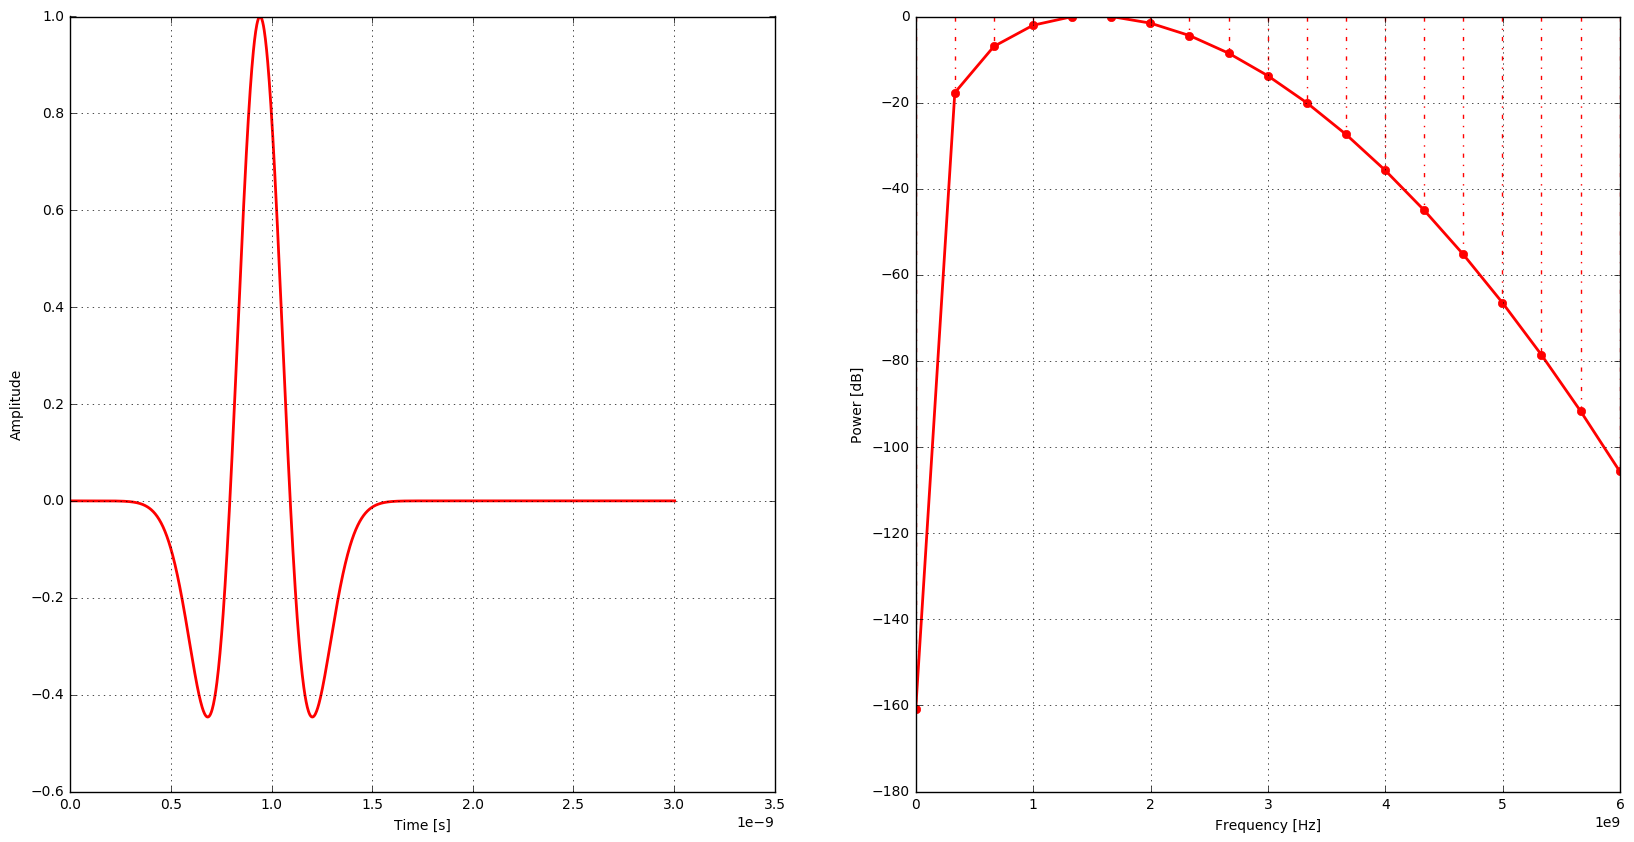

In [3]:
%matplotlib inline
from gprMax.waveforms import Waveform
from tools.plot_source_wave import check_timewindow, mpl_plot

w = Waveform()
w.type = 'ricker'
w.amp = 1
w.freq = 1.5e9
timewindow = 3e-9
dt = 1.926e-12

timewindow, iterations = check_timewindow(timewindow, dt)
plt = mpl_plot(w, timewindow, dt, iterations, fft=True)

By examining the spectrum of a Ricker waveform it is evident much higher frequencies are present, i.e. at a level -40dB from the centre frequency, frequencies 2-3 times as high are present. In this case the highest significant frequency present in the model is likely to be around 4 GHz. To calculate the wavelength at 4 GHz in the half-space (which has the lowest velocity) use:

$$\lambda = \frac{c}{f \sqrt{\epsilon_r}}$$

In [4]:
from math import sqrt

# Speed of light in vacuum (m/s)
c = 299792458

# Highest relative permittivity present in model
er = 6

# Maximum frequency present in model
fmax = 4e9

# Minimum wavelength
wmin = c / (fmax * sqrt(er))

# Maximum spatial resolution
dmin = wmin / 10

print('Minimum wavelength: {:g} m'.format(wmin))
print('Maximum spatial resolution: {:g} m'.format(dmin))

Minimum wavelength: 0.0305974 m
Maximum spatial resolution: 0.00305974 m


This would give a minimum spatial resolution of 3 mm. However, the diameter of the cylinder is 20 mm so would be resolved to 7 cells. Therefore a better choice would be 2 mm which resolves the diameter of the rebar to 10 cells.

    #dx_dy_dz: 0.002 0.002 0.002

The domain size should be enough to enclose the volume of interest, plus allow 10 cells (if using the default value) for the PML absorbing boundary conditions and approximately another 10 cells of between the PML and any objects of interest. In this case the plan is to take a B-scan of the scenario (in the next example) so the domain should be large enough to do that. Although this is a 2D model one cell must be specified in the infinite direction (in this case the z direction) of the domain.

    #domain: 0.240 0.210 0.002

### 4. Choose a time window

It is desired to see the reflection from the cylinder, therefore the time window must be long enough to allow the electromagnetic waves to propagate from the source through the half-space to the cylinder and be reflected back to the receiver.

In [5]:
d = 0.090
t = (2 * d) / (c / sqrt(6))
print('Minimum time window: {:g} s'.format(t))

Minimum time window: 1.47071e-09 s


This is the minimum time required, but the source waveform has a width of 1.2 ns, to allow for the entire source waveform to be reflected back to the receiver an initial time window of 3 ns will be tested.

    #time_window: 3e-9

The time step required for the model is automatically calculated using the CFL condition (for this case in 2D).

### 5. Create the objects

Now physical objects can be created for the half-space and the cylinder. First the ``#box`` command will be used to create the half-space and then the ``#cylinder`` command will be given which will overwrite the properties of the half-space with those of the cylinder at the location of the cylinder.

    #box: 0 0 0 0.240 0.170 0.002 half_space
    #cylinder: 0.120 0.080 0 0.120 0.080 0.002 0.010 pec

## Run the model

You can now run the model using:
    
    python -m gprMax user_models/cylinder_Ascan_2D.in

**Tip**: You can use the ``--geometry-only`` command line argument to build a model and produce any geometry views but not run the simulation. This option is useful for checking the geometry of the model is correct.

In [6]:
import os
from gprMax.gprMax import api

filename = os.path.join(os.pardir, os.pardir, 'user_models', 'cylinder_Ascan_2D.in')
api(filename, n=1, geometry_only=False)


--- Model 1 of 1, input file: /Users/cwarren/Documents/Git-projects/gprMax/user_models/cylinder_Ascan_2D.in -------------------------------------------------------------------------------------------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 1, e0: 8.854187817620389e-12, input_directory: /Users/cwarren/Documents/Git-projects/gprMax/user_models, m0: 1.2566370614359173e-06, number_model_runs: 1, z0: 376.73031346177066}

Model title: A-scan from a metal cylinder buried in a dielectric half-space
Number of threads: 4
Spatial discretisation: 0.002 x 0.002 x 0.002m
Domain size: 0.24 x 0.21 x 0.002m (120 x 105 x 1 = 12600 cells)
Memory (RAM) required: ~71.8MB (32GiB detected)
Time step (at 2D CFL limit): 4.71731e-12 secs
Time window: 3e-09 secs (637 iterations)

Waveform my_ricker of type ricker with maximum amplitude scaling 1, frequency 1.5e+09Hz created.
Hertzian dipole with polarity z at 0.1m, 0.17m, 0m, using waveform my_ricker created

## View the results

### Plot the A-scan

You should have produced an output file ``cylinder_Ascan_2D.out``. You can view the results using:

    python -m tools.plot_Ascan user_models/cylinder_Ascan_2D.out
    
You can use the following code to experiment with plotting different field/current components.

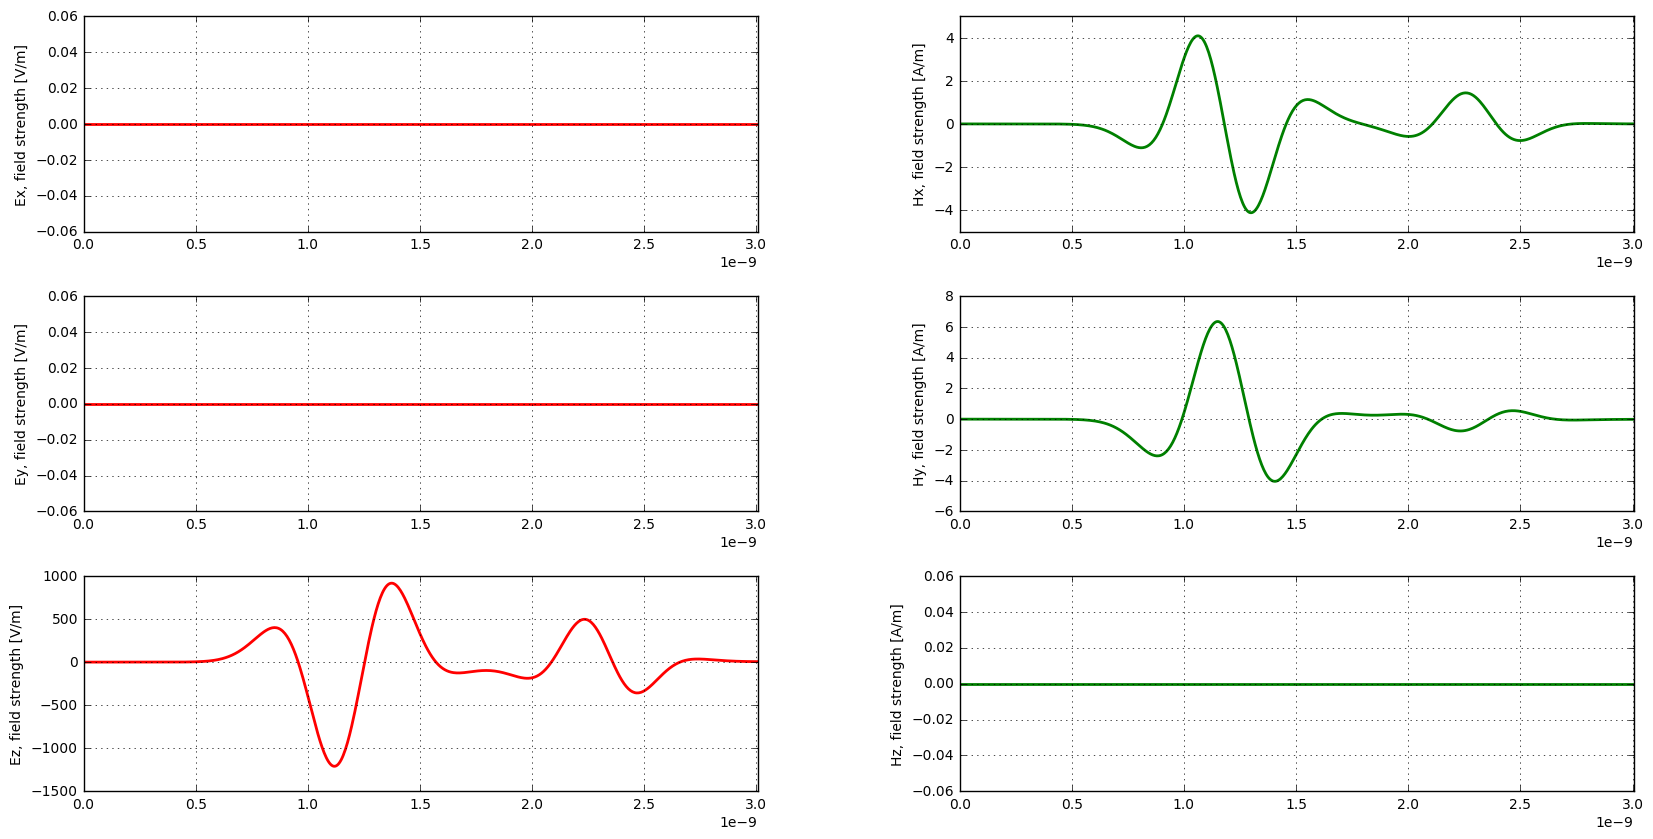

In [4]:
%matplotlib inline
import os
from gprMax.receivers import Rx
from tools.plot_Ascan import mpl_plot

filename = os.path.join(os.pardir, os.pardir, 'user_models', 'cylinder_Ascan_2D.out')
outputs = Rx.defaultoutputs
#outputs = ['Ez']
plt = mpl_plot(filename, outputs, fft=False)